# Проект: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

# Шаг 1. Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import (RandomizedSearchCV, 
                                     train_test_split, 
                                     GridSearchCV)

from sklearn.metrics import (make_scorer, 
                             roc_auc_score, 
                             plot_roc_curve, 
                             accuracy_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay)

from scipy import stats as st

In [3]:
contract_new = pd.read_csv('/datasets/contract_new.csv')

internet_new = pd.read_csv('/datasets/internet_new.csv')

personal_new = pd.read_csv('/datasets/personal_new.csv')

phone_new = pd.read_csv('/datasets/phone_new.csv')

In [4]:
RANDOM_STATE = 290124

# Шаг 2. Исследовательский анализ и предобработка данных

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
list_new = [contract_new, internet_new, personal_new, phone_new]
list_new_name = ['contract_new', 'internet_new', 'personal_new', 'phone_new']

In [7]:
for index, row in enumerate(list_new):
    print("\033[1mНазвание файла:\033[0m", list_new_name[index])
    display(row.head(10))
    print('')
    print(row.info())
    print('')
    print('Количество пропусков:', row.isna().sum())
    print('')
    display(pd.DataFrame(round(row.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm'))
    print('')
    print('Количество явных дубликатов:', row.duplicated().sum())
    print('')

Название файла: contract_new


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Количество пропусков: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64



,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000



Количество явных дубликатов: 0

Название файла: internet_new


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Количество пропусков: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64



,0
customerID,0.000000
InternetService,0.000000
OnlineSecurity,0.000000
OnlineBackup,0.000000
DeviceProtection,0.000000
TechSupport,0.000000
StreamingTV,0.000000
StreamingMovies,0.000000



Количество явных дубликатов: 0

Название файла: personal_new


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Количество пропусков: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64



,0
customerID,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
Dependents,0.000000



Количество явных дубликатов: 0

Название файла: phone_new


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Количество пропусков: customerID       0
MultipleLines    0
dtype: int64



,0
customerID,0.000000
MultipleLines,0.000000



Количество явных дубликатов: 0



Данные состоят из нескольких файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

contract_new:

Тип данных BeginDate и EndDate - object, TotalCharges - object, а должно быть datetime и float64, соответственно. В EndDate, вероятно, под "No" подразумеваются действующие договора. Пропусков нет, явных дубликатов нет.

personal_new, internet_new, phone_new:

Тип данных соответствует, пропусков нет, явных дубликатов нет. Значения в столбце SeniorCitizen закодированы как 0 и 1 в отличие от всех остальных таблиц, где категории имеют текстовый характер.

In [8]:
# Изучим подробнее уникальные значения

for index, row in enumerate(list_new):
    print("\033[1mНазвание файла:\033[0m", list_new_name[index])
    print()
    for column in row.columns:
        print('Название столбца:', column)
        print()
        print(row[column].unique())
        print()

Название файла: contract_new

Название столбца: customerID

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Название столбца: BeginDate

['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-

Как было отмечено выше, в EndDate, вероятно, под "No" подразумеваются действующие договора. Остальные данные вопросов не вызывают.

In [9]:
# Проверка на наличие не числовых значений в "TotalCharges"

contract_new.loc[
    contract_new['TotalCharges'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]'), 
    'TotalCharges'
].unique()

array([' '], dtype=object)

In [10]:
contract_new[contract_new['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [11]:
contract_new[contract_new['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


TotalCharges — общие расходы абонента. Данные отсутствуют только там, где BeginDate (дата начала действия договора) соответствует 2020-02-01. Из условия информация о договорах актуальна на 1 февраля 2020 года, значит TotalCharges = 0. Так как таких наблюдений всего 11, удалим их.

In [12]:
# Обновим индексы

contract_new = contract_new.drop(contract_new.loc[contract_new['TotalCharges'] == ' '].index).reset_index(drop=True)

In [13]:
contract_new[contract_new['EndDate'] == 'No'].shape

(5931, 8)

5931 строка в EndDate (дата окончания действия договора) свидетельствуют о том, что договор действующий. Заменим "No" на актуальную дату и создадим новые признаки с настоящими и бывшими клиентами и продолжительностью действия договора. 

In [14]:
contract_new['EndDate'] = contract_new['EndDate'].replace('No', '2020-02-01')

In [15]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5


In [16]:
# преобразуем тип данных

contract_new['TotalCharges'] = contract_new['TotalCharges'].astype(float)

contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'])

contract_new['EndDate'] = pd.to_datetime(contract_new['EndDate'])

In [17]:
contract_new['Duration'] = (contract_new['EndDate'] - contract_new['BeginDate']).dt.days

In [18]:
def group_users(date):
    if date == pd.Timestamp('2020-02-01'):
        return 'current'
    else:
        return 'former'

In [19]:
contract_new['Status'] = contract_new['EndDate'].apply(group_users)

In [20]:
contract_new['Status'].unique()

array(['current', 'former'], dtype=object)

In [21]:
def plot_pie_charts(columns, columns_rus, dataset):
    for i, data in enumerate(dataset):
        for j, column in enumerate(columns[i]):
            plt.figure(figsize=(3, 3))
            data[column].value_counts().plot(kind='pie', autopct='%1.0f%%')
            plt.xlabel('')
            plt.ylabel('')
            plt.title(columns_rus[i][j])
            plt.show()

In [22]:
columns = [['Type', 'PaperlessBilling', 'PaymentMethod', 'Status'],
        ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
         'TechSupport', 'StreamingTV', 'StreamingMovies'],
        ['gender', 'SeniorCitizen', 'Partner', 'Dependents'],
        ['MultipleLines']] 

columns_rus = [['тип оплаты', 'электронный расчётный лист', 'тип платежа', 'статус'],
               ['тип подключения', 'блокировка опасных сайтов', 'облачное хранилище файлов для резервного копирования данных',
                'антивирус', 'выделенная линия технической поддержки', 'стриминговое телевидение', 'каталог фильмов'],
               ['пол', 'является ли абонент пенсионером', 'есть ли у абонента супруг или супруга', 'есть ли у абонента дети'],
               ['подключение телефона к нескольким линиям одновременно']]

list_new = [contract_new, internet_new, personal_new, phone_new]

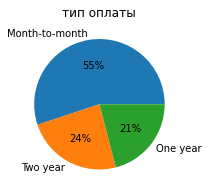

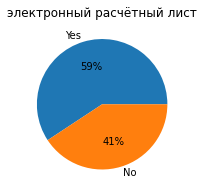

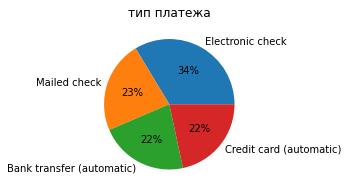

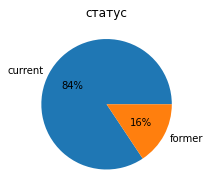

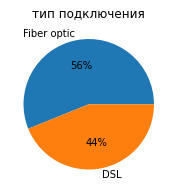

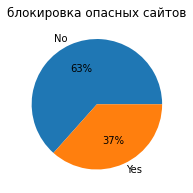

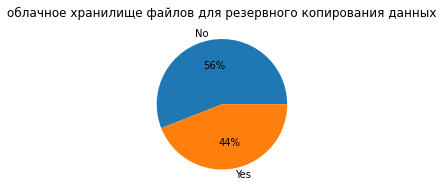

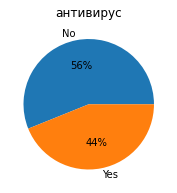

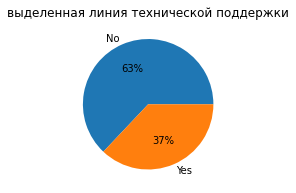

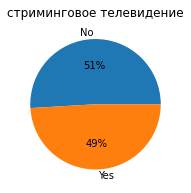

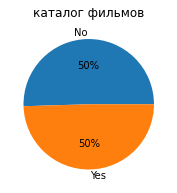

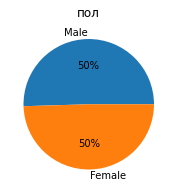

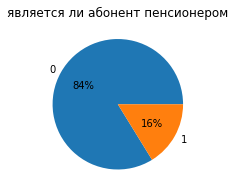

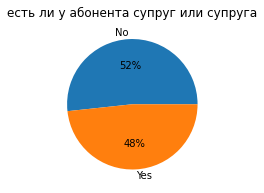

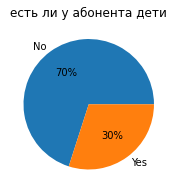

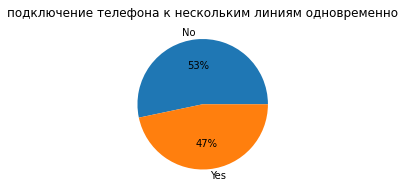

In [23]:
plot_pie_charts(columns, columns_rus, list_new)

- 55% платят ежемесячно, 21% и 24% - раз в год и два, соответственно;
- 59% получают электронный расчетный лист;
- 34% оплачивают через электронный чек, 23% - через почтовый чек, по 22% - через кредитную карту и банковским переводом (автоматически);
- 84% продолжают пользоваться услугами компании;


- 56% имеют подключение через оптоволоконный кабель;
- 37% пользуются услугой блокировки небезопасных сайтов;
- 44% пользуются услугой облачное хранилище файлов для резервного копирования данных;
- 44% устновили антивирус;
- 37% имеют выделенную линию технической поддержки;
- 49% имеют стриминговое телевиденье ;
- 50% имеют каталог фильмов.


- 50/50% соотношение полов;
- 16% являются пенсионерами;
- 48% состоят в браке;
- 30% имеют детей.


- 47% имеют подключение к нескольким линиям одновременно.

Скорее всего, электронный расчетный чек, тип платежа не влияют на вероятность расторжения договора. Информация об интернет-услугах тоже, кажется, не имеет значимости, так как предполагается, что от них можно отказаться, и вопрос больше будет свяазан с ежемесячными расходами. Однако набор услуг может характеризовать пользователей, поэтому пока избавляться от этих данных не будем.

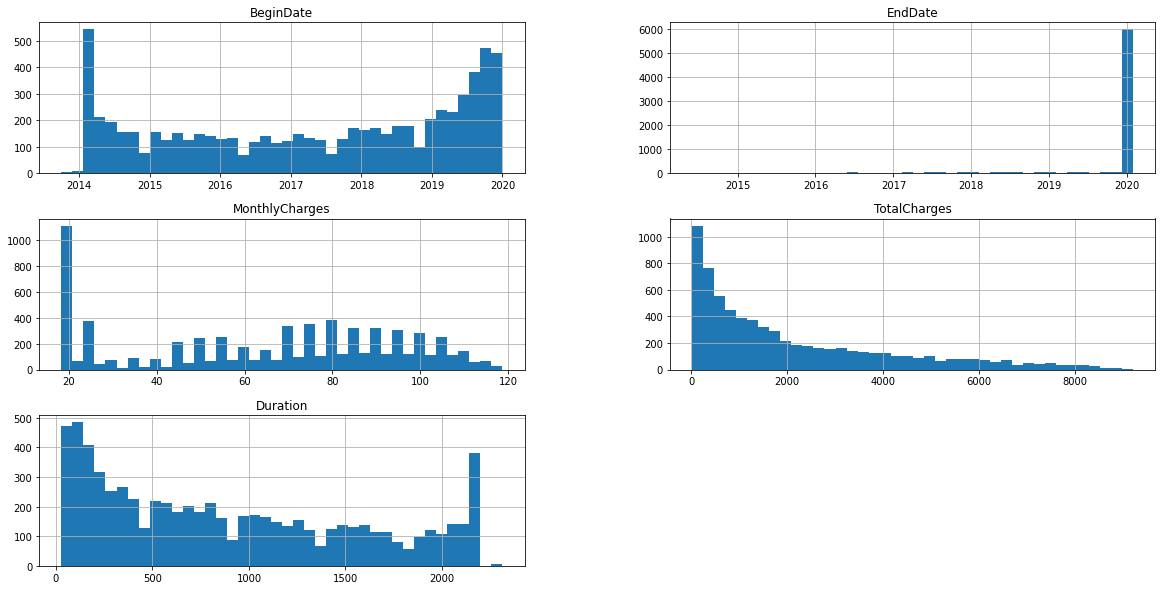

In [24]:
contract_new.hist(figsize = (20,10), bins = 40)
plt.show()

C 2019 года отмечается увеличение количества заключенных договоров, на момент 2020-02-01 5931 из 7043 - действуют.
Расходы за месяц для большинства около 20, общие расходы до 1000, общая продолжительность действия договра до года, что, скорее, связано с увеличнием количества пользователей за последний год. 

**Промежуточный вывод**

Данные состоят из нескольких файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.


contract_new:

Изначально тип данных BeginDate и EndDate - object, TotalCharges - object, поэтому они были преобразованы в datetime и float64, соответственно. В EndDate 5931 строка была "No", что свидетельствовало о том, что договор действующий, поэтому "No" заменили на актуальную дату. Данные отсутствовали в TotalCharges (общие расходы абонента), где дата начала действия договора была 2020-02-01, значит TotalCharges = 0, и так как таких наблюдений всего 11, они были удалены. Пропусков и явных дубликатов не было. Были созданы новые признаки с настоящими и бывшими клиентами и продолжительностью действия договора.

personal_new, internet_new, phone_new: 

Тип данных соответствовал, пропусков и явных дубликатов не было. Значения в столбце SeniorCitizen были закодированы как 0 и 1 в отличие от всех остальных таблиц, где категории имели текстовый характер.

- 55% платят ежемесячно, 21% и 24% - раз в год и два, соответственно;
- 59% получают электронный расчетный лист; 
- 34% оплачивают через электронный чек, 23% - через почтовый чек, по 22% - через кредитную карту и банковским переводом (автоматически);
- 84% продолжают пользоваться услугами компании;


- 56% имеют подключение через оптоволоконный кабель;
- 37% пользуются услугой блокировки небезопасных сайтов;
- 44% используют облачное хранилище файлов для резервного копирования данных;
- 44% устновили антивирус;
- 37% имеют выделенную линию технической поддержки;
- 49% имеют стриминговое телевиденье ;
- 50% имеют каталог фильмов.


- 50/50% соотношение полов;
- 16% являются пенсионерами;
- 48% состоят в браке;
- 30% имеют детей.
- 47% имеют подключение к нескольким линиям одновременно.


C 2019 года отмечается увеличение количества заключенных договоров, на момент 2020-02-01 5931 из 7043 - действуют.
Расходы за месяц для большинства около 20, общие расходы до 1000, общая продолжительность действия договра до года, что, скорее, связано с увеличнием количества пользователей за последний год. 

Скорее всего, электронный расчетный чек, тип платежа не влияют на вероятность расторжения договора. Избавимся от них в следующем шаге. Информация об интернет-услугах тоже, кажется, не имеет значимости, так как предполагается, что от них можно отказаться, и вопрос больше будет связан с ежемесячными расходами. Однако набор услуг может характеризовать пользователей, поэтому пока избавляться от этих данных не будем.

# Шаг 3. Объединение данных


Объединим выбранные признаки в один датафрейм по ключу.

In [25]:
total_new = contract_new.merge(personal_new, on='customerID', how='left')
total_new = total_new.merge(phone_new, on='customerID', how='left')
total_new = total_new.merge(internet_new, on='customerID', how='left')

In [26]:
total_new = total_new.drop(['PaperlessBilling', 'PaymentMethod'], axis = 1)

total_new.head(10)

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,Duration,Status,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,29.85,31.04,31,current,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,56.95,2071.84,1036,current,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,53.85,226.17,123,current,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,42.30,1960.60,1371,current,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,70.70,353.50,153,current,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,99.65,1150.96,337,current,Female,0,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,89.10,2058.21,671,current,Male,0,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,29.75,300.48,306,current,Female,0,No,No,NaN,DSL,Yes,No,No,No,No,No
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,104.80,3573.68,945,current,Female,0,Yes,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,56.15,1628.35,882,former,Male,0,No,Yes,No,DSL,Yes,Yes,No,No,No,No


**Промежуточный вывод**

Таблицы были объеденены по CustomerID. Признаки PaperlessBilling и PaymentMethod были удалены. 

# Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

In [27]:
total_new.head()

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,Duration,Status,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,29.85,31.04,31,current,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,56.95,2071.84,1036,current,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,53.85,226.17,123,current,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,42.30,1960.60,1371,current,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,70.70,353.50,153,current,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [28]:
print(total_new.info())
print('')
print('Количество пропусков:', total_new.isna().sum())
print('')
display(pd.DataFrame(round(total_new.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm'))
print('')
print('Количество явных дубликатов:', total_new.duplicated().sum())
print('')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   MonthlyCharges    7032 non-null   float64       
 5   TotalCharges      7032 non-null   float64       
 6   Duration          7032 non-null   int64         
 7   Status            7032 non-null   object        
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  MultipleLines     6352 non-null   object        
 13  InternetService   5512 non-null   object        
 14  OnlineSecurity    5512 n

,0
StreamingMovies,21.600000
StreamingTV,21.600000
TechSupport,21.600000
DeviceProtection,21.600000
OnlineBackup,21.600000
OnlineSecurity,21.600000
InternetService,21.600000
MultipleLines,9.700000
BeginDate,0.000000
Dependents,0.000000



Количество явных дубликатов: 0



In [29]:
total_new.loc[total_new['StreamingMovies'].isna() == True]

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,Duration,Status,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
11,7469-LKBCI,2018-10-01,2020-02-01,Two year,18.95,312.30,488,current,Male,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,8191-XWSZG,2015-10-01,2020-02-01,One year,20.65,1106.01,1584,current,Female,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,1680-VDCWW,2019-02-01,2020-02-01,One year,19.80,237.60,365,current,Male,0,Yes,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,1066-JKSGK,2019-11-01,2020-02-01,Month-to-month,20.15,61.05,92,current,Male,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,7310-EGVHZ,2020-01-01,2020-02-01,Month-to-month,20.20,22.22,31,current,Male,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7006,4807-IZYOZ,2015-11-01,2020-02-01,Two year,20.65,1053.15,1553,current,Female,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7008,9710-NJERN,2016-11-01,2020-02-01,Two year,20.15,785.85,1187,current,Female,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7009,9837-FWLCH,2019-02-01,2020-02-01,Month-to-month,19.20,246.53,365,current,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7019,0871-OPBXW,2019-12-01,2020-02-01,Month-to-month,20.05,40.10,62,current,Female,0,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


21.6% пропусков будет серьезно сказываться на качестве модели, по этой же причине заполнить пропуски наиболее часто встречающимся вариантом не является верным, а специфические группы выделить сейчас не представляется возможным. Заменим пустые значения заглушкой "unknown"

In [30]:
total_new.loc[total_new['MultipleLines'].isna() == True]

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,Duration,Status,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,29.85,31.04,31,current,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,42.30,1960.60,1371,current,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,29.75,300.48,306,current,Female,0,No,No,NaN,DSL,Yes,No,No,No,No,No
20,8779-QRDMV,2019-11-01,2020-02-01,Month-to-month,39.65,118.95,92,current,Male,1,No,No,NaN,DSL,No,No,Yes,No,No,Yes
27,8665-UTDHZ,2019-11-01,2020-02-01,Month-to-month,30.20,96.04,92,current,Male,0,Yes,Yes,NaN,DSL,No,Yes,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,4501-VCPFK,2017-12-01,2019-04-01,Month-to-month,35.75,572.00,486,former,Male,0,No,No,NaN,DSL,No,No,Yes,Yes,No,No
6996,2274-XUATA,2014-02-01,2020-02-01,Two year,63.10,4861.22,2191,current,Male,1,Yes,No,NaN,DSL,Yes,Yes,Yes,Yes,Yes,Yes
7018,2235-DWLJU,2019-08-01,2020-02-01,Month-to-month,44.40,266.40,184,current,Female,1,No,No,NaN,DSL,No,No,No,No,Yes,Yes
7025,7750-EYXWZ,2019-02-01,2020-02-01,One year,60.65,727.80,365,current,Female,0,No,No,NaN,DSL,No,Yes,Yes,Yes,Yes,Yes


Об этих данных можно сказать, что и про пропуски выше, только процент меньше - 9.7

In [31]:
total_new = total_new.fillna('unknown')

display(pd.DataFrame(round(total_new.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm'))

,0
customerID,0.000000
BeginDate,0.000000
StreamingTV,0.000000
TechSupport,0.000000
DeviceProtection,0.000000
OnlineBackup,0.000000
OnlineSecurity,0.000000
InternetService,0.000000
MultipleLines,0.000000
Dependents,0.000000


In [32]:
def plot_pie_charts_2(columns, columns_rus, dataset):
    for i, column in enumerate(columns):
        plt.figure(figsize=(3, 3))         
        dataset[column].value_counts().plot(kind='pie', autopct='%1.0f%%')
        plt.xlabel('')
        plt.ylabel('')
        plt.title(columns_rus[i])
        plt.show()

In [33]:
columns_2 = ['Type', 'Status', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
           'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','gender', 
           'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']

columns_rus_2 = ['тип оплаты', 'статус', 'тип подключения', 'блокировка опасных сайтов', 'облачное хранилище файлов для резервного копирования данных',
                'антивирус', 'выделенная линия технической поддержки', 'стриминговое телевидение', 'каталог фильмов','пол', 
               'является ли абонент пенсионером', 'есть ли у абонента супруг или супруга', 'есть ли у абонента дети', 'подключение телефона к нескольким линиям одновременно']

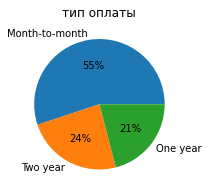

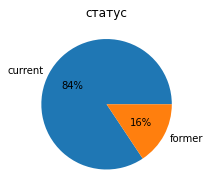

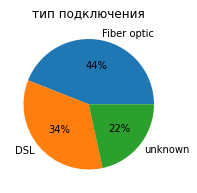

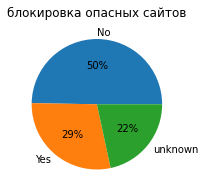

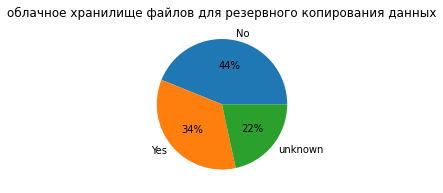

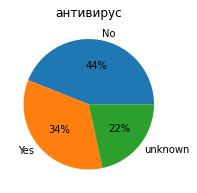

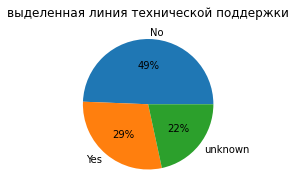

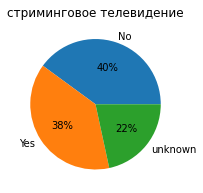

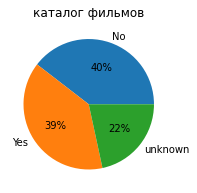

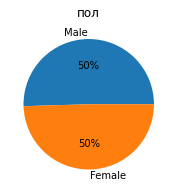

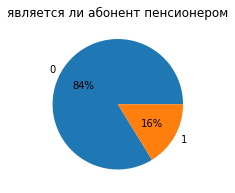

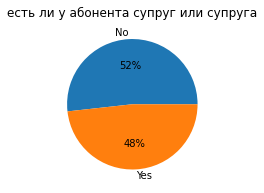

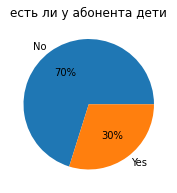

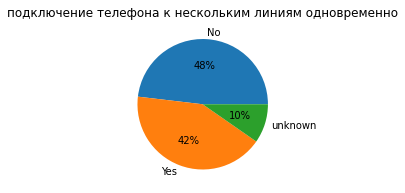

In [34]:
plot_pie_charts_2(columns_2, columns_rus_2, total_new)

- 55% платят ежемесячно, 21% и 24% - раз в год и два, соответственно;
- 84% продолжают пользоваться услугами компании;


- 44% имеют подключение через оптоволоконный кабель, 34% - через цифровую абонентскую линию, 22% - нет данных;
- 29% пользуются услугой блокировки небезопасных сайтов, 50% - нет, 22% - нет данных;
- 34% используют облачное хранилище файлов для резервного копирования данных, 44% - нет, 22% - нет данных;
- 34% устновили антивирус, 44% - нет, 22% - нет данных;
- 29% имеют выделенную линию технической поддержки, 49% - нет, 22% - нет данных;
- 38% имеют стриминговое телевиденье, 40% - нет, 22% - нет данных;
- 39% имеют каталог фильмов, 40% - нет, 22% - нет данных;


- 50/50% соотношение полов;
- 16% являются пенсионерами;
- 48% состоят в браке;
- 30% имеют детей.


- 42% имеют подключение к нескольким линиям одновременно, 48% - к одной, 10% - нет данных.


In [35]:
def plot_bar_charts(column, columns_rus):
    for i, column in enumerate(column):
        
        percentages = total_new.groupby("Status")[column].value_counts(normalize=True) * 100
        
        ax = total_new.groupby("Status")[column].value_counts(normalize=True).unstack().plot(kind="bar", figsize=(10, 5))
        plt.xlabel(columns_rus[i])
        plt.ylabel("Проценты")
        plt.title(columns_rus[i])

        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            
            if height > 0:  
                ax.annotate(f'{height:.2f}%', (x + width/2, y + height), ha='center')
        
        plt.legend()
        plt.xticks(rotation = 0)
        plt.show()

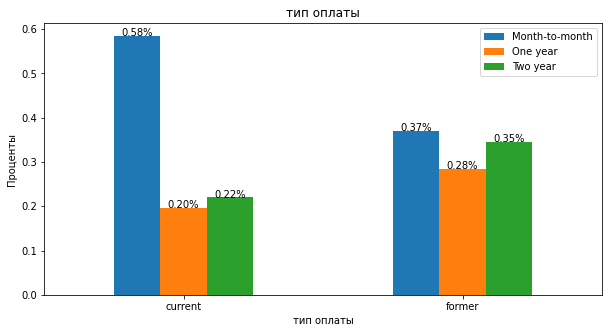

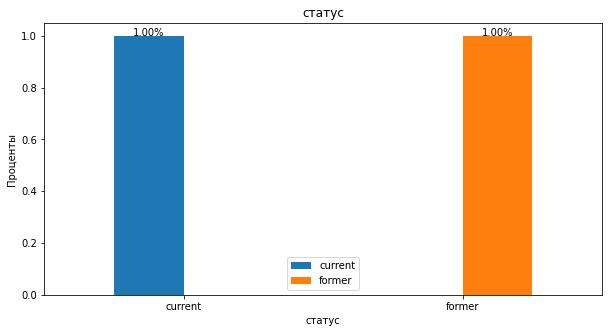

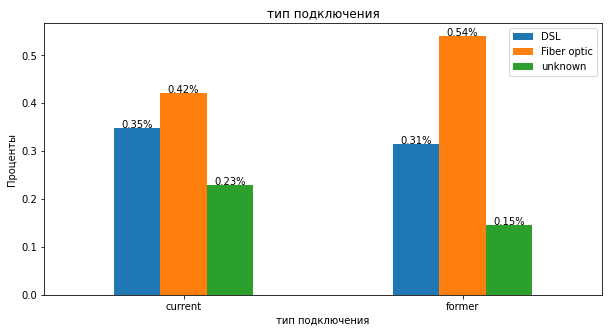

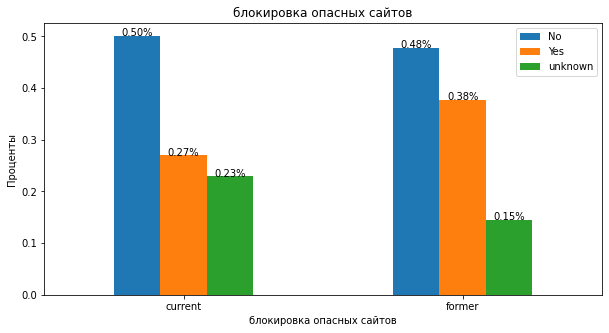

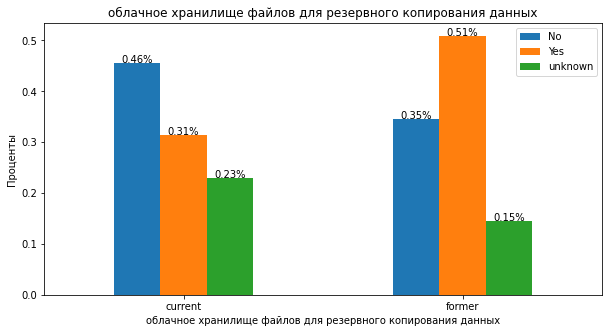

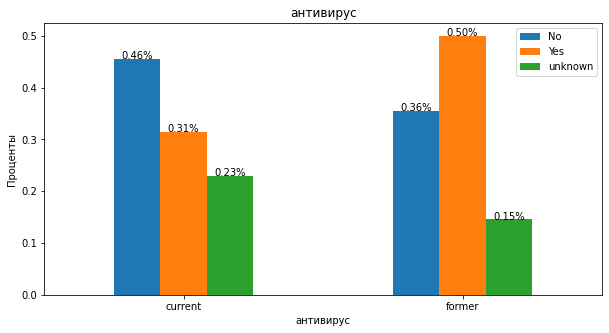

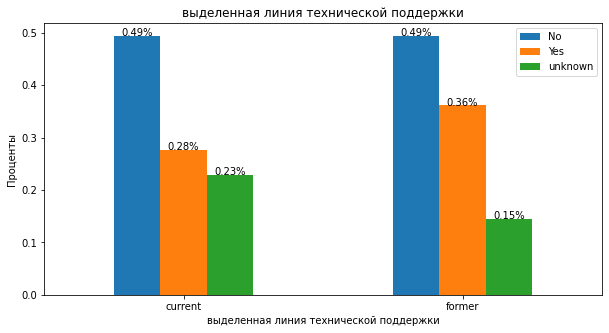

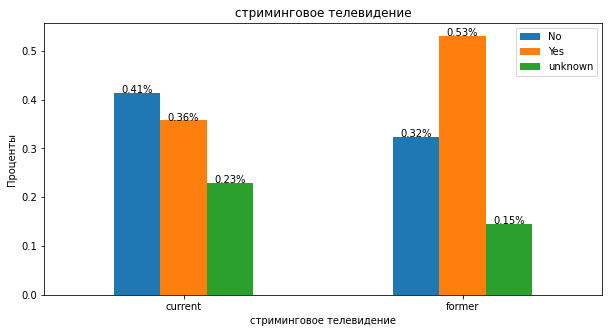

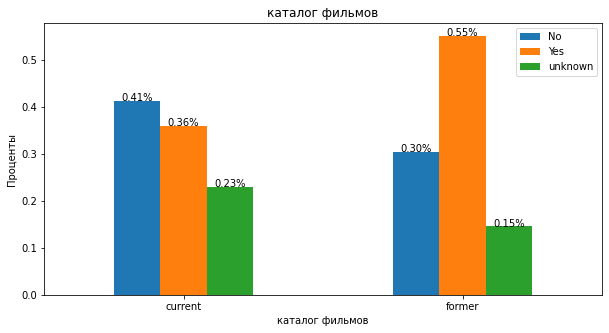

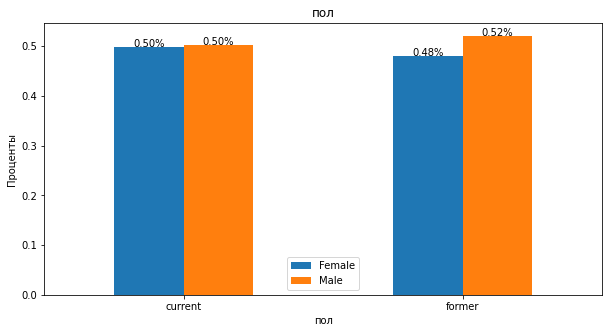

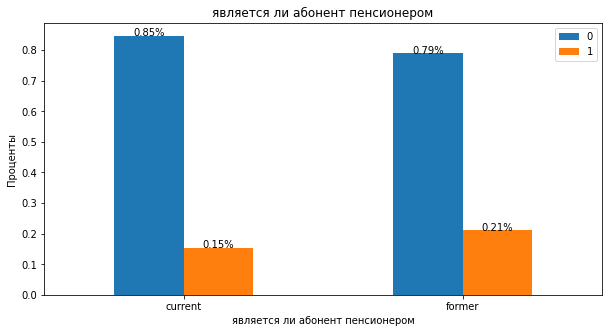

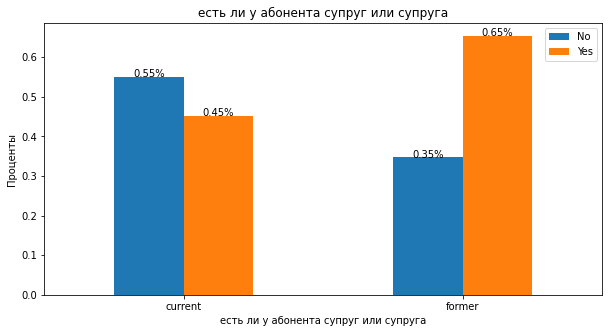

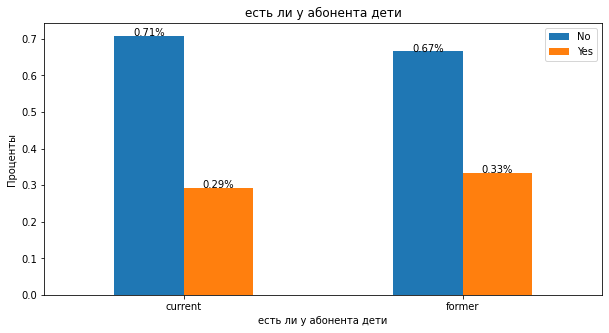

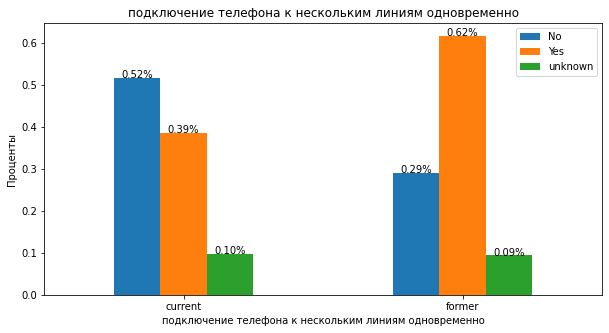

In [36]:
plot_bar_charts(columns_2, columns_rus_2)

При сравнении текущих и бывших клиентов можно выделить следующие особенности:
- Текущие пользователи предпочитают платить ежемесячно;
- Текущие пользователи реже используют облачное хранилище файлов для резервного копирования данных, антивирус, стриминговое телевидение и каталог фильмов. 
- Текущие пользователи чаще не состоят в браке
- Текущие пользователи имеют одно подключение к одной линии


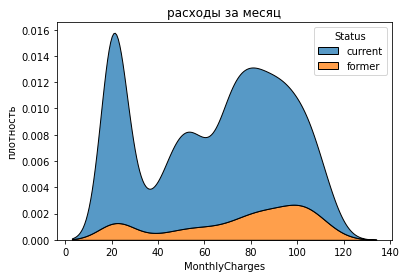

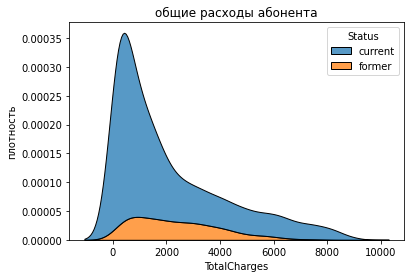

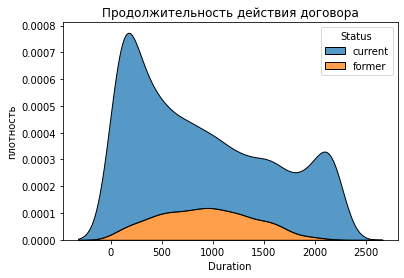

In [37]:
columns_3 = ['MonthlyCharges', 'TotalCharges', 'Duration']

columns_rus_3 = ['расходы за месяц', 'общие расходы абонента', 'Продолжительность действия договора']

for i, column in enumerate(columns_3):
    sns.kdeplot(data=total_new, x = column, hue="Status", multiple="stack")
    
    plt.ylabel("плотность")
    plt.title(columns_rus_3[i])

    plt.show()

In [38]:
total_new.groupby("Status").describe()

MonthlyCharges                                                      \
                 count       mean        std    min     25%    50%     75%   
Status                                                                       
current         5931.0  62.803043  29.841911  18.25  30.125  69.25  87.325   
former          1101.0  75.546004  29.116213  18.40  56.150  84.20  99.500   

                TotalCharges                                             \
            max        count         mean          std    min       25%   
Status                                                                    
current  118.60       5931.0  2071.701614  2194.122190  19.05   376.225   
former   118.75       1101.0  2371.377275  1581.862275  77.84  1048.050   

                                   Duration                               \
             50%      75%      max    count       mean         std   min   
Status                                                                     
current  1194.28  3176.00  9221.38   5931.0  895.33856  716.588322  31.0   
former   2139.03  3404.91  7649.76   1101.0  924.86376  458.771309  28.0   

                                      SeniorCitizen                           \
           25%    50%     75%     max         count      mean       std  min   
Status                                                                         
current  245.0  702.0  1523.0  2314.0        5931.0  0.153431  0.360433  0.0   
former   577.0  915.0  1249.0  2129.0        1101.0  0.210718  0.408003  0.0   

                             
         25%  50%  75%  max  
Status                       
current  0.0  0.0  0.0  1.0  
former   0.0  0.0  0.0  1.0

In [64]:
def stat(columns):
    for i, column in enumerate(columns):
        
        sample_1 = total_new.loc[total_new['Status'] == 'current'][column]
        sample_2 = total_new.loc[total_new['Status'] == 'former'][column]
        
        alpha = 0.05 

        results = st.ttest_ind(sample_1, sample_2)
        
        print(columns_rus[i])
        
        print('p-значение:', results.pvalue)
    
        if results.pvalue < alpha:
            print('Отвергаем нулевую гипотезу')
        else:
            print('Не получилось отвергнуть нулевую гипотезу') 
        
        print()

In [65]:
stat(columns_3)

['тип оплаты', 'электронный расчётный лист', 'тип платежа', 'статус']
p-значение: 1.526961409599664e-38
Отвергаем нулевую гипотезу

['тип подключения', 'блокировка опасных сайтов', 'облачное хранилище файлов для резервного копирования данных', 'антивирус', 'выделенная линия технической поддержки', 'стриминговое телевидение', 'каталог фильмов']
p-значение: 1.5266437242636794e-05
Отвергаем нулевую гипотезу

['пол', 'является ли абонент пенсионером', 'есть ли у абонента супруг или супруга', 'есть ли у абонента дети']
p-значение: 0.1875833518734748
Не получилось отвергнуть нулевую гипотезу



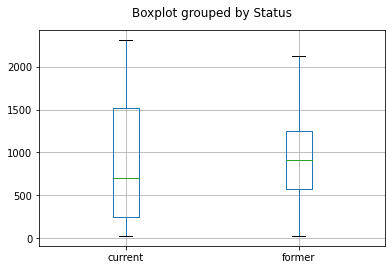

In [41]:
total_new.boxplot('Duration', 'Status')
plt.xlabel('')
plt.ylabel('')
plt.title('')

plt.show()

Расходы за месяц и общие расходы абонента между группами различаются (69.25 против 84.20 и 1194.28 против 2139.03, соответственно). Продолжительность действия договора значимо не различается (702.0 против 915.0). 

In [42]:
total_new_corr = total_new[['BeginDate', 'EndDate', 'Type', 'MonthlyCharges',
                           'TotalCharges', 'Duration', 'Status', 'gender', 'SeniorCitizen',
                           'Partner', 'Dependents', 'MultipleLines', 'InternetService',
                           'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                           'StreamingTV', 'StreamingMovies']]

In [43]:
total_new_corr.head()

,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,Duration,Status,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,2020-01-01,2020-02-01,Month-to-month,29.85,31.04,31,current,Female,0,Yes,No,unknown,DSL,No,Yes,No,No,No,No
1,2017-04-01,2020-02-01,One year,56.95,2071.84,1036,current,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,2019-10-01,2020-02-01,Month-to-month,53.85,226.17,123,current,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,2016-05-01,2020-02-01,One year,42.30,1960.60,1371,current,Male,0,No,No,unknown,DSL,Yes,No,Yes,Yes,No,No
4,2019-09-01,2020-02-01,Month-to-month,70.70,353.50,153,current,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [44]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'Duration']

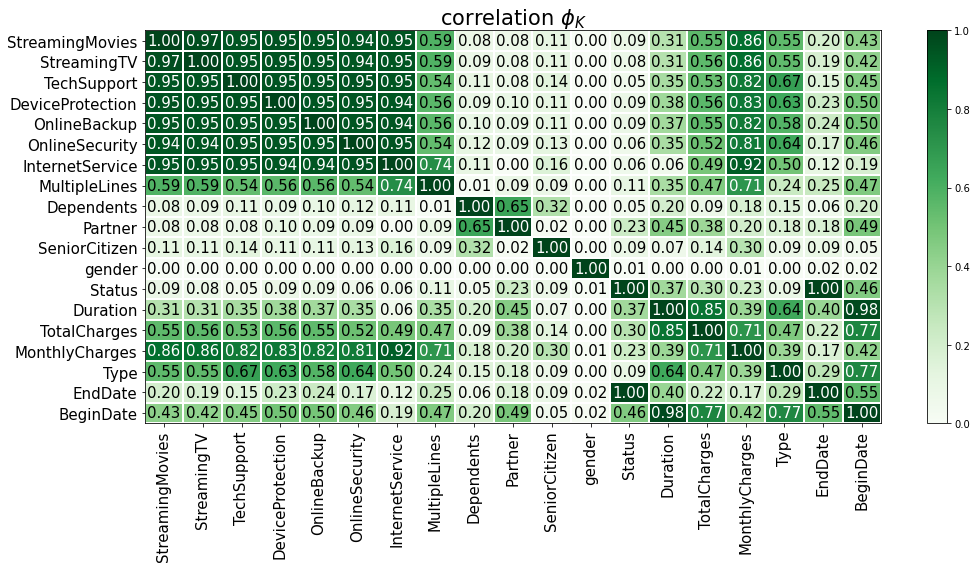

In [45]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'Duration']
phik_overview = total_new_corr.phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)


plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 8))
plt.tight_layout()

Мы можем видеть, что связь около единицы между текущим статусом и датой окончания действия договора, длительностью действия договора и датой начала действия договора - ничего неожиданного. 

Существует сильная корреляция между переменными, характеризующими набор интернет-услуг (словно, их продают только пакетами), также между интернет-услугами и ежемесяными расходами, что логично. Сильная связь есть между продолжительностью действия договора и общими расходами абонента, что тоже понятно. 

Средней силы корреляция между подключением телефона к нескольким линиям одновременно, общими расходами абонента, типом оплаты, датой начала действия договора и интернет-услугами, между наличием детей и семейным положением, между типом платежа и длительностью действия договора, датой начала действия договора, между датой начала действия договора и общими расходами абонента. 

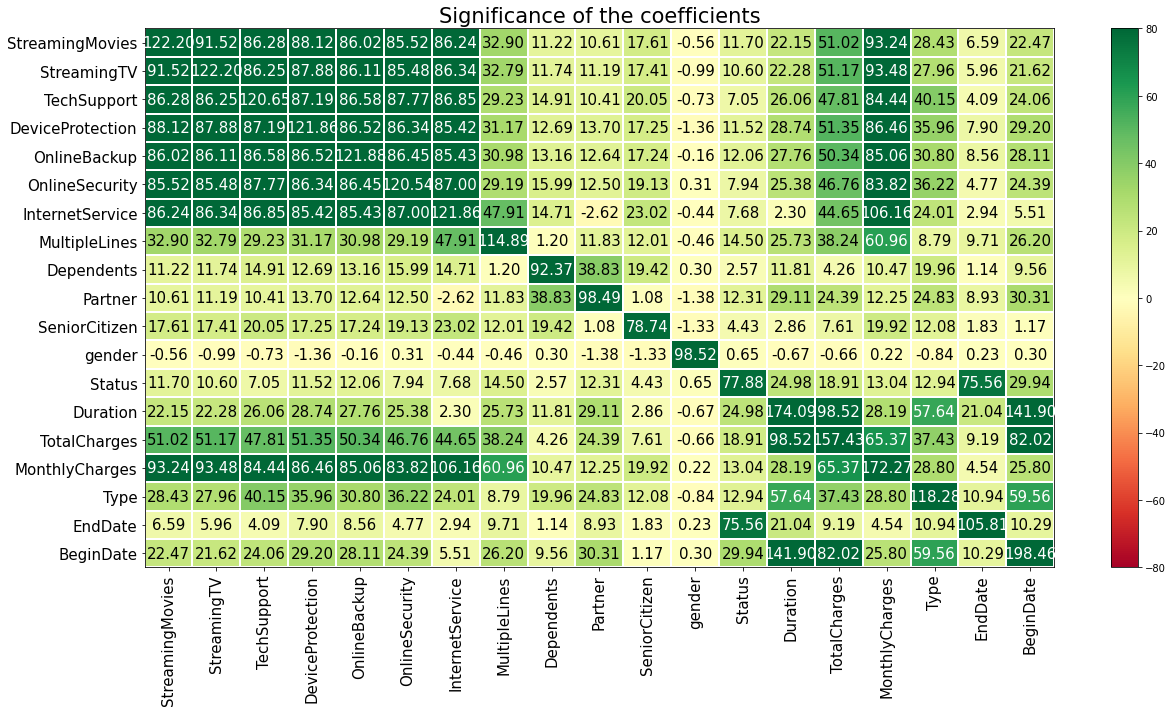

In [46]:
significance_overview = total_new_corr.significance_matrix(interval_cols=interval_cols)

plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-80, vmax=80, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 10))
plt.tight_layout()

Сюрпризов в статистической значимости не произошло. 

/opt/conda/lib/python3.9/site-packages/phik/phik.py:319: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.sqrt(


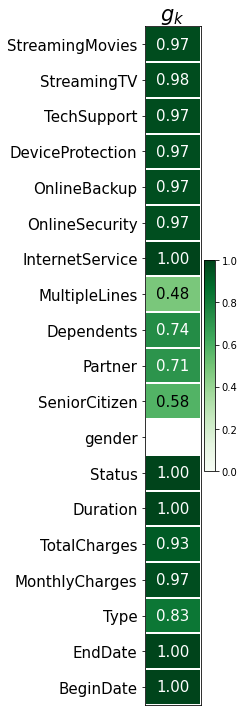

In [47]:
global_correlation, global_labels = total_new_corr.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,10),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

Глобальная корреляция показывает, что большинство переменных можно смоделировать с использованием других переменных, хуже всех этот показатель для признаков: MultipleLines, SeniorCitizen, gender.

Исходя из вышесказанного, удалим данные об интернет-услугах из-за мультиколлинеарности, удалим столбец с информацией о наличии детей, пенсионного статуса, датами начала и окончания действия договра.

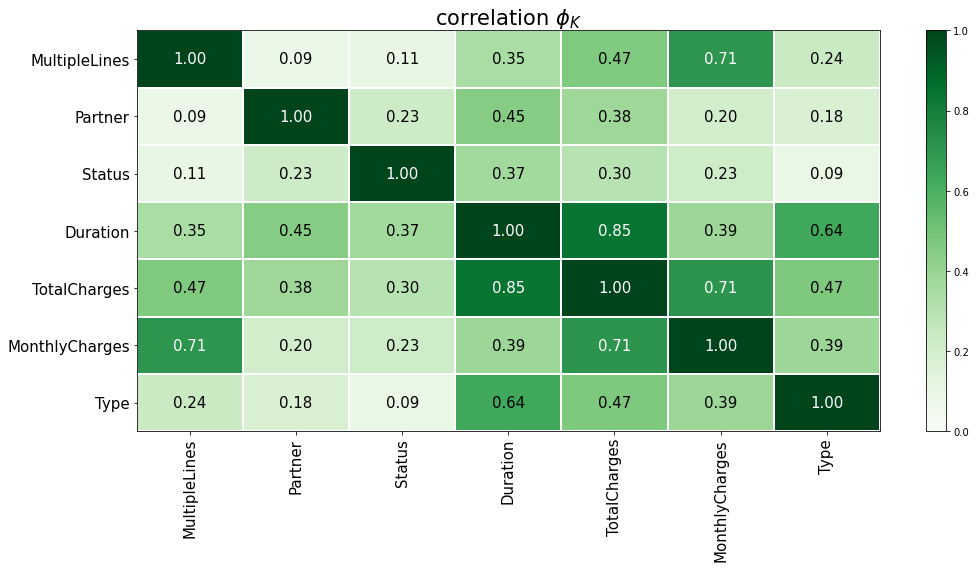

In [48]:
total_new_corr_2 = total_new[['Type', 'MonthlyCharges',
                           'TotalCharges', 'Duration', 'Status', 
                           'Partner', 'MultipleLines']]


interval_cols = ['MonthlyCharges', 'TotalCharges', 'Duration']
phik_overview = total_new_corr_2.phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)


plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 8))
plt.tight_layout()

Таким образом, окончательная таблица выглядит следующим образом

In [49]:
total_new_corr_2.head()

,Type,MonthlyCharges,TotalCharges,Duration,Status,Partner,MultipleLines
0,Month-to-month,29.85,31.04,31,current,Yes,unknown
1,One year,56.95,2071.84,1036,current,No,No
2,Month-to-month,53.85,226.17,123,current,No,No
3,One year,42.30,1960.60,1371,current,No,unknown
4,Month-to-month,70.70,353.50,153,current,No,No


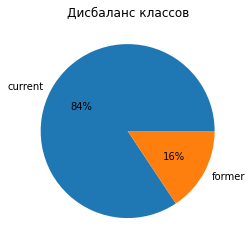

In [50]:
total_new_corr_2['Status'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.xlabel('')
plt.ylabel('')
plt.title('Дисбаланс классов')
plt.show()

**Промежуточный вывод**

21.6% пропусков данных об интернет услугах серьезно бы сказывался на качестве модели, по этой причине заполнить пропуски наиболее часто встречающимся вариантом не подходило, а специфические группы выделить, чтобы их заполнить таргетно, не представлялось возможным. Из-за этого заменили пустые значения заглушкой "unknown"

Тоже самое можно было сказать об информации о подключении телефона к нескольким линиям одновременно. Процент пропусков был меньше - 9.7%, они также были заполнены заглушкой. 

Таким образом, данные о пользователях выглядят следующим образом:

- 55% платят ежемесячно, 21% и 24% - раз в год и два, соответственно;
- 84% продолжают пользоваться услугами компании;


- 44% имеют подключение через оптоволоконный кабель, 34% - через цифровую абонентскую линию, 22% - нет данных;
- 29% пользуются услугой блокировки небезопасных сайтов, 50% - нет, 22% - нет данных;
- 34% используют облачное хранилище файлов для резервного копирования данных, 44% - нет, 22% - нет данных;
- 34% устновили антивирус, 44% - нет, 22% - нет данных;
- 29% имеют выделенную линию технической поддержки, 49% - нет, 22% - нет данных;
- 38% имеют стриминговое телевиденье, 40% - нет, 22% - нет данных;
- 39% имеют каталог фильмов, 40% - нет, 22% - нет данных;


- 50/50% соотношение полов;
- 16% являются пенсионерами;
- 48% состоят в браке;
- 30% имеют детей.


- 42% имеют подключение к нескольким линиям одновременно, 48% - к одной, 10% - нет данных.


При сравнении текущих и бывших клиентов были выделены следующие особенности:


- Текущие пользователи предпочитают платить ежемесячно;
- Текущие пользователи реже используют облачное хранилище файлов для резервного копирования данных, антивирус, стриминговое телевидение и каталог фильмов; 
- Текущие пользователи чаще не состоят в браке;
- Текущие пользователи имеют одно подключение к одной линии.

Расходы за месяц и общие расходы абонента между группами различались (медиана: 69.25 против 84.20 и 1194.28 против 2139.03, соответственно). Продолжительность действия договора значимо не различалась (702.0 против 915.0).

При корреляционном анализе было отмечено следующее:

- Очень сильная связь (около единицы) была между текущим статусом и датой окончания действия договора, длительностью действия договора и датой начала действия договора.

- Сильная корреляция была между переменными, характеризующими набор интернет-услуг (словно, их продают только пакетами); между интернет-услугами и ежемесяными расходами; между продолжительностью действия договора и общими расходами абонента.

- Средней силы корреляция была между подключением телефона к нескольким линиям одновременно, общими расходами абонента, типом оплаты, датой начала действия договора и интернет-услугами; между наличием детей и семейным положением; между типом платежа и длительностью действия договора, датой начала действия договора; между датой начала действия договора и общими расходами абонента. 

Сюрпризов в статистической значимости корреляции не произошло. 

Глобальная корреляция показала, что большинство переменных можно смоделировать с использованием других переменных, хуже всех этот показатель для признаков: MultipleLines, SeniorCitizen, gender.

Исходя из вышесказанного, были удалены данные об интернет-услугах из-за мультиколлинеарности, признаки с информацией о наличии детей, пенсионного статуса, датами начала и окончания действия договора.

Таким образом, финальная таблица включает 7 признаков. Дисбаланс классов значительный: текущих пользователей - 84%. 

# Шаг 5. Подготовка данных


Выполним подготовку данных для обучения модели. Разделим данные на две выборки, выполним масштабирование и кодирование.

In [51]:
features = total_new_corr_2.drop(['Status'], axis=1)
target = total_new_corr_2['Status']

features_train, features_test,target_train, target_test  = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [52]:
display(features_train.info())

features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 1915 to 4106
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            5274 non-null   object 
 1   MonthlyCharges  5274 non-null   float64
 2   TotalCharges    5274 non-null   float64
 3   Duration        5274 non-null   int64  
 4   Partner         5274 non-null   object 
 5   MultipleLines   5274 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 288.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 3527 to 3439
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            1758 non-null   object 
 1   MonthlyCharges  1758 non-null   float64
 2   TotalCharges    1758 non-null   float64
 3   Duration        1758 non-null   int64  
 4   Partner         1758 non-null   object 
 5   MultipleLines   1758 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 96.1+ KB


In [53]:
numeric_features = ['MonthlyCharges', 'TotalCharges', 'Duration']
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


categorical_features = ['Type', 'Partner', 'MultipleLines']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

**Промежуточный вывод**

Данные были разделены на две выборки. 

# Шаг 6. Обучение моделей машинного обучения

Обучим модели и подберем гиперпараметры.

In [54]:
pipeline_lin = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [55]:
param_grid = {
    "classifier__C": [0.1, 1.0, 10, 100, 200],
    "classifier__penalty": ['l1', 'l2'], 
}
        
search_cv_lin = RandomizedSearchCV(pipeline_lin, param_grid, n_iter=5, random_state=RANDOM_STATE, scoring='roc_auc')

search_cv_lin.fit(features_train, target_train)

print("Best params:", search_cv_lin.best_params_)
print(f"Internal CV score: {search_cv_lin.best_score_:.3f}")

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

Best params: {'classifier__penalty': 'l2', 'classifier__C': 1.0}
Internal CV score: 0.737


In [56]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(preprocessor, model_rf)

In [57]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': range(5, 200, 5),
    'randomforestclassifier__max_depth': range(2, 10, 1)
}

search_cv_rf = RandomizedSearchCV(pipline_rf, param_distributions=param_grid_rf, random_state=RANDOM_STATE, scoring='roc_auc')

search_cv_rf.fit(features_train, target_train)

search_cv_rf_best_score = search_cv_rf.best_score_
search_cv_rf_best_params = search_cv_rf.best_params_

print(f'best_score: {search_cv_rf_best_score}')
print(f'best_params: {search_cv_rf_best_params}')

best_score: 0.8236639944393337
best_params: {'randomforestclassifier__n_estimators': 195, 'randomforestclassifier__max_depth': 8}


In [58]:
cat_features = ['Type', 'Partner', 'MultipleLines']

model_cat = CatBoostClassifier(random_state=RANDOM_STATE)

param_grid = {
    'iterations': np.arange(100, 300, 50),
    'learning_rate': np.arange(0.1, 0.3, 0.05)
}


scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

grid_search = GridSearchCV(
    estimator=model_cat,
    param_grid=param_grid,
    scoring=scorer,
    cv=5
)

grid_search.fit(features_train, target_train, cat_features=cat_features, verbose=False, plot=False)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best AUC: {best_score}")

Best parameters: {'iterations': 250, 'learning_rate': 0.25000000000000006}
Best AUC: 0.9037043268467198


**Промежуточный вывод**

Было построено 3 можеди с подборами гиперпараметров в каждой. ROC AUC для модели логистической регресии составила 0.737, для случайного леса - 0.82, для CatBoost - 0.90.


# Шаг 7. Выбор лучшей модели

Выберем лучшую модель и проверим её качество на тестовой выборке.

Лучшая модель по итогам кросс-валидации CatBoost с параметрами iterations: 250, learning_rate: 0.25. AUC составила: 0.90. 

Показатель ROC AUC: 0.9212908374126083   accuracy: 0.9209328782707622


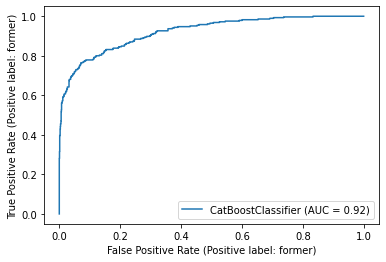

In [59]:
model_cat_best = CatBoostClassifier(random_state=RANDOM_STATE, iterations = 250, learning_rate = 0.25000000000000006)

model_cat_best.fit(features_train, target_train, cat_features=cat_features, verbose=False, plot=False)

predict_test = model_cat_best.predict(features_test)
predict_proba = model_cat_best.predict_proba(features_test)

# Расчет "ROC AUC" и "accuracy" 
roc_auc = roc_auc_score(target_test, predict_proba[:, 1])
accuracy = accuracy_score(target_test, predict_test)

print('Показатель ROC AUC:', roc_auc, " ", "accuracy:", accuracy)
plot_roc_curve(model_cat_best, features_test, target_test)

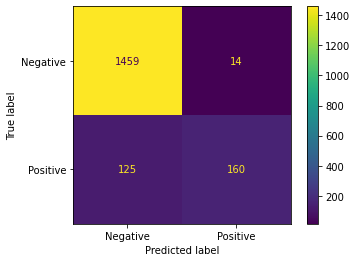

In [60]:
cm = confusion_matrix(target_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot()
plt.show()

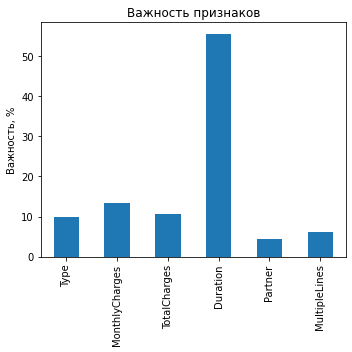

In [61]:
feature_importance = pd.Series(model_cat_best.get_feature_importance(), features_test.columns)

fig, ax = plt.subplots(figsize=(5,5))
feature_importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

**Промежуточный вывод**

Показатель ROC AUC на тестовой выборке составил 0.9212908374126083, а accuracy - 0.9209328782707622, что говорит о хорошем качестве модели. Таким образом, количество ложноотрицательных и ложноположительных составило для каждого около 8%. Наиболее важным признаком является длительность действия договора, далее в порядке убывания: ежемесячные расходы, общие расходы, тип платежа, подключение телефона к нескольким линиям одновременно и статус брака. 

# Шаг 8. Общий вывод и рекомендации заказчику

Данные состояли из нескольких файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.


В целом, исходные данные в таблицах были полные: пропусков в большом количестве и явных дубликатов не было. Были выполнены следующие преобразваония: BeginDate, EndDate и TotalCharges были преобразованы в datetime и float64, соответственно; в EndDate значения  "No" заменили на актуальную дату; пропуски в TotalCharges были удалены. 


После объединения таблиц по CustomerID 21.6% пропусков данных было в  интернет услугах и 9.7% - в информации о подключении телефона к нескольким линиям одновременно. Они были заполнены заглушкой “unknown”. Признаки PaperlessBilling и PaymentMethod были удалены. Были созданы 2 новых признака: статус клиента и длительность действия договора. 


Таким образом, данные о пользователях выглядели следующим образом:


- 55% платят ежемесячно, 21% и 24% - раз в год и два, соответственно;
- 84% продолжают пользоваться услугами компании;
- 44% имеют подключение через оптоволоконный кабель, 34% - через цифровую абонентскую линию, 22% - нет данных;
- 29% пользуются услугой блокировки небезопасных сайтов, 50% - нет, 22% - нет данных;
- 34% используют облачное хранилище файлов для резервного копирования данных, 44% - нет, 22% - нет данных;
- 34% установили антивирус, 44% - нет, 22% - нет данных;
- 29% имеют выделенную линию технической поддержки, 49% - нет, 22% - нет данных;
- 38% имеют стриминговое телевиденье, 40% - нет, 22% - нет данных;
- 39% имеют каталог фильмов, 40% - нет, 22% - нет данных;
- 50/50% соотношение полов;
- 16% являются пенсионерами;
- 48% состоят в браке;
- 30% имеют детей.
- 42% имеют подключение к нескольким линиям одновременно, 48% - к одной, 10% - нет данных.


При сравнении текущих и бывших клиентов были выделены следующие особенности: текущие пользователи предпочитают платить ежемесячно; реже используют облачное хранилище файлов для резервного копирования данных, антивирус, стриминговое телевидение и каталог фильмов; чаще не состоят в браке; имеют одно подключение к одной линии. Расходы за месяц и общие расходы абонента между группами различались (медиана: 69.25 против 84.20 и 1194.28 против 2139.03, соответственно). Продолжительность действия договора значимо не различалась (медиана: 702.0 против 915.0).


Глобальная корреляция показала, что большинство переменных можно смоделировать с использованием других переменных, хуже всех этот показатель был для признаков: MultipleLines, SeniorCitizen, gender. После корреляционного анализа последние 2 признака, а также данные об интернет-услугах, признаки с информацией о наличии детей, датами начала и окончания действия договора были удалены из-за мультиколлинеарности.


Таким образом, финальная таблица включала 7 признаков:
- Type — тип оплаты: раз в год-два или ежемесячно;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.
- Duration – длительность действия договора
- Partner — есть ли у абонента супруг или супруга;
- MultipleLines — подключение телефона к нескольким линиям одновременно.
- Status, который был целевым признаком. 


Дисбаланс классов был значительный: текущих пользователей - 84%. Данные были разделены на две выборки (тестовая = 0.25) и были масштабированы и закодированы признаки.


Всего было построено 3 модели с подборами гиперпараметров в каждой. ROC AUC для модели логистической регресии составила 0.737, для случайного леса - 0.82, для CatBoost - 0.90. CatBoost имела параметры: iterations - 250, learning_rate - 0.25, random_state – 290124.


Показатель ROC AUC и accuracy  на тестовой выборке составили 0.92, что говорит о хорошем качестве модели. Таким образом, количество ложноотрицательных и ложноположительных составило для каждого около 8%. Наиболее важным признаком являлась длительность действия договора, далее в порядке убывания: ежемесячные расходы, общие расходы, тип платежа, подключение телефона к нескольким линиям одновременно и статус брака.


Таким образом, модель обладает необходимой точностью.  Заказчику для повышения качества будущих моделей важно обратить внимание на недостаток данных в таблице об интернет услугах, разобраться с чем это связано. Эти данные коррелируют с общими и ежемесячными расходами, которые уже влияют на результат модели. Также для стабильной работы модели необходимо считать новый признак – длительность действия договора. 
